In [33]:
import pandas as pd
import numpy as np
import datetime as dt
import math
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [34]:
consumption_data = pd.read_csv(R'C:\Users\ecemnaz.bay\Documents\GitHub\fall19-Ecemnaz0\consumption_data.csv', encoding = 'unicode_escape')
consumption_data1 = pd.read_csv(R'C:\Users\ecemnaz.bay\Documents\GitHub\fall19-Ecemnaz0\consumption_data.csv', encoding = 'unicode_escape')
consumption_data.head()

,Tarih,Saat,Tüketim Miktarý (MWh)
0,01.01.2016,00:00,"26.277,24"
1,01.01.2016,01:00,"24.991,82"
2,01.01.2016,02:00,"23.532,61"
3,01.01.2016,03:00,"22.464,78"
4,01.01.2016,04:00,"22.002,91"


Format of both the consumption and date fields of the data downloaded from website were not  proper to proocess. Thus, the format of consumption has been changed to float and date to date-time data type.

In [35]:
consumption = consumption_data['Tüketim Miktarý (MWh)'].tolist()
datetimes = consumption_data['Tarih'].tolist()
dates = consumption_data['Tarih'].tolist()
hours = consumption_data['Saat'].tolist()

for i in range (0,consumption_data.shape[0]):
    datetimes[i] = datetimes[i].replace('.','/') + " " + hours[i]
    dates[i] = dates[i].replace('.','/')
    consumption[i] = float(consumption[i].replace('.','').replace(',','.'))
    
datetimes_list = [dt.datetime.strptime(date, '%d/%m/%Y %H:%M') for date in datetimes]
dates_list = [dt.datetime.strptime(date, '%d/%m/%Y') for date in dates]

consumption_data['Datetime'] = datetimes_list
consumption_data['Tarih'] = dates_list
consumption_data['Tüketim Miktarý (MWh)'] = consumption

consumption_data_lag = consumption_data

consumption_data.head()

,Tarih,Saat,Tüketim Miktarý (MWh),Datetime
0,2016-01-01,00:00,26277.24,2016-01-01 00:00:00
1,2016-01-01,01:00,24991.82,2016-01-01 01:00:00
2,2016-01-01,02:00,23532.61,2016-01-01 02:00:00
3,2016-01-01,03:00,22464.78,2016-01-01 03:00:00
4,2016-01-01,04:00,22002.91,2016-01-01 04:00:00


2 and 7 days were substracted from date data to get consumption of 2 days and 7 days ago at the same hour. That information is added to the table. 
There was a missing date within the data set. There are 2 days which will try to use consumption of that day (2 days and 7 days after that missing day). Due to that missing information, the prediction would be errornous.
To be able to clear that error from training set, 0 values were inserted as the consumption of missing day, into the lines for the days that are 2 days and 7 days after it. 
After having the complete table, the lines having 0 values as lag consumption were dropped. 

In [36]:
lag168 = []
lag48 = []
lag168_date = []
lag48_date = []

for i in range (0,consumption_data_lag.shape[0]):
    try:
        tmp_data = (consumption_data_lag[consumption_data_lag['Datetime'] == consumption_data_lag.iloc[i]['Datetime'] \
        - dt.timedelta(days=7)]['Tüketim Miktarý (MWh)']).values[0]
    except:
        tmp_data = 0.0
    lag168.append(tmp_data)
    
    try:
        tmp_data_1 = (consumption_data_lag[consumption_data_lag['Datetime'] == consumption_data_lag.iloc[i]['Datetime'] \
        - dt.timedelta(days=2)]['Tüketim Miktarý (MWh)']).values[0]
    except:
        tmp_data_1 = 0.0
    lag48.append(tmp_data_1)
    
    lag168_date.append(consumption_data_lag.iloc[i]['Datetime'] - dt.timedelta(days=7))
    lag48_date.append(consumption_data_lag.iloc[i]['Datetime'] - dt.timedelta(days=2))

consumption_data_lag['lag168_consumption'] = lag168
consumption_data_lag['lag168_datetime'] = lag168_date
consumption_data_lag['lag48_consumption'] = lag48
consumption_data_lag['lag48_datetime'] = lag48_date

consumption_data_lag = consumption_data_lag[(consumption_data_lag.lag168_consumption != 0.0) & (consumption_data_lag.lag48_consumption != 0.0)]

consumption_data_lag.tail()

,Tarih,Saat,Tüketim Miktarý (MWh),Datetime,lag168_consumption,lag168_datetime,lag48_consumption,lag48_datetime
33931,2019-11-15,19:00,36395.99,2019-11-15 19:00:00,35642.08,2019-11-08 19:00:00,36826.95,2019-11-13 19:00:00
33932,2019-11-15,20:00,35556.60,2019-11-15 20:00:00,34776.28,2019-11-08 20:00:00,35750.20,2019-11-13 20:00:00
33933,2019-11-15,21:00,34657.92,2019-11-15 21:00:00,33940.11,2019-11-08 21:00:00,34889.02,2019-11-13 21:00:00
33934,2019-11-15,22:00,33846.45,2019-11-15 22:00:00,33093.52,2019-11-08 22:00:00,33698.67,2019-11-13 22:00:00
33935,2019-11-15,23:00,32542.81,2019-11-15 23:00:00,31998.52,2019-11-08 23:00:00,32563.79,2019-11-13 23:00:00


In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Part a

Predictions were made as lag consumption values of the days, lag 168 hour and lag 48 hour. Using the dates after 1 November 2019 MAPE of these prediction approaches were calculated. Lag 168 was resulted with a better MAPE value, as it takes day seasonality into consideration by using the same day 1 week before as the prediction. 

In [38]:
test_data = consumption_data_lag[consumption_data_lag.Tarih >= dt.datetime(2019,11,1)]
y_true = test_data['Tüketim Miktarý (MWh)']
y_pred = test_data['lag168_consumption']
lag168_mape = mean_absolute_percentage_error(y_true,y_pred)
y_pred1 = test_data['lag48_consumption']
lag48_mape = mean_absolute_percentage_error(y_true,y_pred1)

print('MAPE for using lag 168 data : ' + str(lag168_mape))
print('MAPE for using lag 48 data : ' + str(lag48_mape))

MAPE for using lag 168 data : 3.3131106381630095
MAPE for using lag 48 data : 7.137720753129708


## Part b 

A linear regression model has been fit using lag 168 and lag 48 consumptions. Train data was from 1 January 2016 to 1 November 2019(including). The MAPE obtained even worse than the value obtained in part a using lag 168 as prediction. The reason behind was loosing the consumption correlation between hours.

In [39]:
train_data = consumption_data_lag[consumption_data_lag.Tarih <= dt.datetime(2019,11,1)]
X = train_data[['lag168_consumption','lag48_consumption']] 
Y = train_data['Tüketim Miktarý (MWh)']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

y_true = test_data['Tüketim Miktarý (MWh)']
x_predict = test_data[['lag168_consumption','lag48_consumption']] 
y_predict = regr.predict(x_predict)

linear_mape1 = mean_absolute_percentage_error(y_true,y_predict)

print('MAPE for linear regression : ' + str(linear_mape1))
print('coefficient of lag168 : ' + str(regr.coef_[0]) + ' and coefficient of lag48 : ' + str(regr.coef_[1]))
print('Interception value is ' + str(regr.intercept_))

MAPE for linear regression : 4.0345611480244195
coefficient of lag168 : 0.6253808831506078 and coefficient of lag48 : 0.3250154398816605
Interception value is 1620.4562879900514


## Part c

Data was filtered and specific linear regression models were fitted for each 24 hour. Train and test data sets were used as the same periods, train data was from 1 January 2016 to 1 November 2019(including). 
Obtained models were tested and MAPE values were calculated. Results show that some hours are more predictable than others, whereas some other hours are more prone to behave differantly than past observations. 
For example, MAPE values for night hours were considerably lower than those calculated for noon hours.

In [40]:
hours_data = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00',\
              '10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00',\
              '20:00','21:00','22:00','23:00']
mape_results = []
regr = linear_model.LinearRegression() 
for i in range (0,24):
    train_data1 = train_data[train_data.Saat == hours_data[i]]
    test_data1 = test_data[test_data.Saat == hours_data[i]] 
    X = train_data1[['lag168_consumption','lag48_consumption']] 
    Y = train_data1['Tüketim Miktarý (MWh)']
    regr.fit(X, Y)
    y_true = test_data1['Tüketim Miktarý (MWh)']
    x_predict = test_data1[['lag168_consumption','lag48_consumption']] 
    y_predict = regr.predict(x_predict)

    linear_mape = mean_absolute_percentage_error(y_true,y_predict)
    print('For ' + hours_data[i] + ' MAPE result is ' + str(linear_mape)) 
    print('coefficient of lag168 : ' + str(regr.coef_[0]) + ' and coefficient of lag48 : ' + str(regr.coef_[1]))
    print('')
    mape_results.append(linear_mape)



For 00:00 MAPE result is 2.9662399193134252
coefficient of lag168 : 0.42062534798088147 and coefficient of lag48 : 0.5020426289063771

For 01:00 MAPE result is 3.0513862436406423
coefficient of lag168 : 0.4149366248350373 and coefficient of lag48 : 0.5063528190638994

For 02:00 MAPE result is 3.1614750116738892
coefficient of lag168 : 0.40772252338255227 and coefficient of lag48 : 0.5081443770390243

For 03:00 MAPE result is 3.1660553779127056
coefficient of lag168 : 0.41080524071547175 and coefficient of lag48 : 0.5010870051141206

For 04:00 MAPE result is 3.1533916271446665
coefficient of lag168 : 0.42735336722277495 and coefficient of lag48 : 0.48235438676783543

For 05:00 MAPE result is 3.095079520884516
coefficient of lag168 : 0.4564273898349272 and coefficient of lag48 : 0.4453431395608629

For 06:00 MAPE result is 3.564467513420965
coefficient of lag168 : 0.5254192707995685 and coefficient of lag48 : 0.3764473367614274

For 07:00 MAPE result is 4.262845873281719
coefficient of l

## Part d

In this section, the data transformed to the wide format. 
In order to consider the collinearity between our predictiors (past consumptions) we used lasso regression method which is a penalized regression approach.  

In [41]:
consumption = consumption_data1['Tüketim Miktarý (MWh)'].tolist()
datetimes = consumption_data1['Tarih'].tolist()
dates = consumption_data1['Tarih'].tolist()
hours = consumption_data1['Saat'].tolist()

for i in range (0,consumption_data1.shape[0]):
    datetimes[i] = datetimes[i].replace('.','/') + " " + hours[i]
    dates[i] = dates[i].replace('.','/')
    consumption[i] = float(consumption[i].replace('.','').replace(',','.'))
    
datetimes_list = [dt.datetime.strptime(date, '%d/%m/%Y %H:%M') for date in datetimes]
dates_list = [dt.datetime.strptime(date, '%d/%m/%Y') for date in dates]

consumption_data1['Datetime'] = datetimes_list
consumption_data1['Tarih'] = dates_list
consumption_data1['Tüketim Miktarý (MWh)'] = consumption

In [42]:
consumption_data_seasonality = consumption_data1
tmp_data = []
tmp_data1 = []
tmp_data2 = []
lag_data1_list = []
lag_data2_list = []
tmp_data1 = []
tmp_data2 = []

for i in range (0,consumption_data_seasonality.shape[0]):
    tmp_data1 = (consumption_data_seasonality[consumption_data_seasonality['Tarih'] == consumption_data_seasonality.iloc[i]['Tarih'] \
    - dt.timedelta(days=7)]['Tüketim Miktarý (MWh)']).values
    tmp_data2 = (consumption_data_seasonality[consumption_data_seasonality['Tarih'] == consumption_data_seasonality.iloc[i]['Tarih'] \
    - dt.timedelta(days=2)]['Tüketim Miktarý (MWh)']).values
    lag_data1_list.append(tmp_data1)
    lag_data2_list.append(tmp_data2)
    tmp_data1 = []
    tmp_data2 = []
     

In [43]:
column_data = []
column_data2 = []
for i in range(0,24):
    column_data.append('Lag_day7_hour_' + str(i))
    column_data2.append('Lag_day2_hour_' + str(i))
lags1 = pd.DataFrame(lag_data1_list,columns=column_data)
lags2 = pd.DataFrame(lag_data2_list,columns=column_data2)
lags1['Datetime'] = consumption_data_seasonality['Datetime']
lags2['Datetime'] = consumption_data_seasonality['Datetime']
lags = pd.merge(lags1, lags2, how='left', on=['Datetime'])
consumption_data_seasonality_new = pd.merge(consumption_data_seasonality, lags, how='left', on=['Datetime'])


In [44]:
consumption_data_seasonality_new = (consumption_data_seasonality_new.dropna()).reset_index(drop=True)
consumption_data_seasonality_new

,Tarih,Saat,Tüketim Miktarý (MWh),Datetime,Lag_day7_hour_0,Lag_day7_hour_1,Lag_day7_hour_2,Lag_day7_hour_3,Lag_day7_hour_4,Lag_day7_hour_5,...,Lag_day2_hour_14,Lag_day2_hour_15,Lag_day2_hour_16,Lag_day2_hour_17,Lag_day2_hour_18,Lag_day2_hour_19,Lag_day2_hour_20,Lag_day2_hour_21,Lag_day2_hour_22,Lag_day2_hour_23
0,2016-01-08,00:00,28602.02,2016-01-08 00:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
1,2016-01-08,01:00,27112.37,2016-01-08 01:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
2,2016-01-08,02:00,25975.34,2016-01-08 02:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
3,2016-01-08,03:00,25315.55,2016-01-08 03:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
4,2016-01-08,04:00,25128.15,2016-01-08 04:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
5,2016-01-08,05:00,25356.22,2016-01-08 05:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
6,2016-01-08,06:00,26338.72,2016-01-08 06:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
7,2016-01-08,07:00,28086.42,2016-01-08 07:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
8,2016-01-08,08:00,32702.24,2016-01-08 08:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
9,2016-01-08,09:00,35788.17,2016-01-08 09:00:00,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65


MAPE values were calculated with new predictions obtained via lasso regresion. We already foresee the collinearity between hour consumptions. Having these relations within the model results with lower MAPE values as seen below.

In [45]:
train_data = consumption_data_seasonality_new[consumption_data_seasonality_new.Tarih <= dt.datetime(2019,11,1)]
test_data = consumption_data_seasonality_new[consumption_data_seasonality_new.Tarih >= dt.datetime(2019,11,1)]
train_condition = column_data + column_data2
mape_results_lasso = []
for i in range(0,24):
    train_data_hourly = train_data[train_data.Saat == hours_data[i]]
    test_data_hourly = test_data[test_data.Saat == hours_data[i]]
    alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
    regr = linear_model.LassoCV(cv=10, normalize=True, tol=0.001, selection='random', random_state=43, alphas=alpha)
    X = train_data_hourly[train_condition] 
    Y = train_data_hourly['Tüketim Miktarý (MWh)']
    regr.fit(X, Y)
    y_true = test_data_hourly['Tüketim Miktarý (MWh)']
    x_predict = test_data_hourly[train_condition] 
    y_predict = regr.predict(x_predict)

    lasso_mape = mean_absolute_percentage_error(y_true,y_predict)
    print('For ' + hours_data[i] + ' MAPE result is ' + str(lasso_mape)) 
    #print(regr.coef_)
    print('')
    lasso_mape = float(lasso_mape)
    mape_results_lasso.append(lasso_mape)


For 00:00 MAPE result is 1.985409211997912

For 01:00 MAPE result is 2.032717872631114

For 02:00 MAPE result is 2.0856061014683642

For 03:00 MAPE result is 2.0414524798141587

For 04:00 MAPE result is 1.9742512488635962

For 05:00 MAPE result is 1.8384078834075848

For 06:00 MAPE result is 1.6728372405395753

For 07:00 MAPE result is 1.9718507899007014

For 08:00 MAPE result is 2.875272087218882

For 09:00 MAPE result is 3.5103338441818503

For 10:00 MAPE result is 3.628226922375756

For 11:00 MAPE result is 3.6544176393615007

For 12:00 MAPE result is 3.8632169009106883

For 13:00 MAPE result is 3.795184684603387

For 14:00 MAPE result is 3.965177754124347

For 15:00 MAPE result is 3.5572621017095805

For 16:00 MAPE result is 3.0187333986814977

For 17:00 MAPE result is 2.592128618237405

For 18:00 MAPE result is 2.356682806154584

For 19:00 MAPE result is 2.0668017858755534

For 20:00 MAPE result is 1.7404352741218643

For 21:00 MAPE result is 1.8839690112981329

For 22:00 MAPE res

## Part f

MAPE values are calculated for each model are represented in below figure. 
As expected and discussed in the earlier parts, MAPE value obtained via lag 168 prediction is strongly better than either lag 48 prediction as it considers day seasonality. 
Linear regression model also resulted with a worse MAPE as it loses the collinearities.
Among all approaches, the penalized regression modelresulted better as it takes collinearity into consideration. 

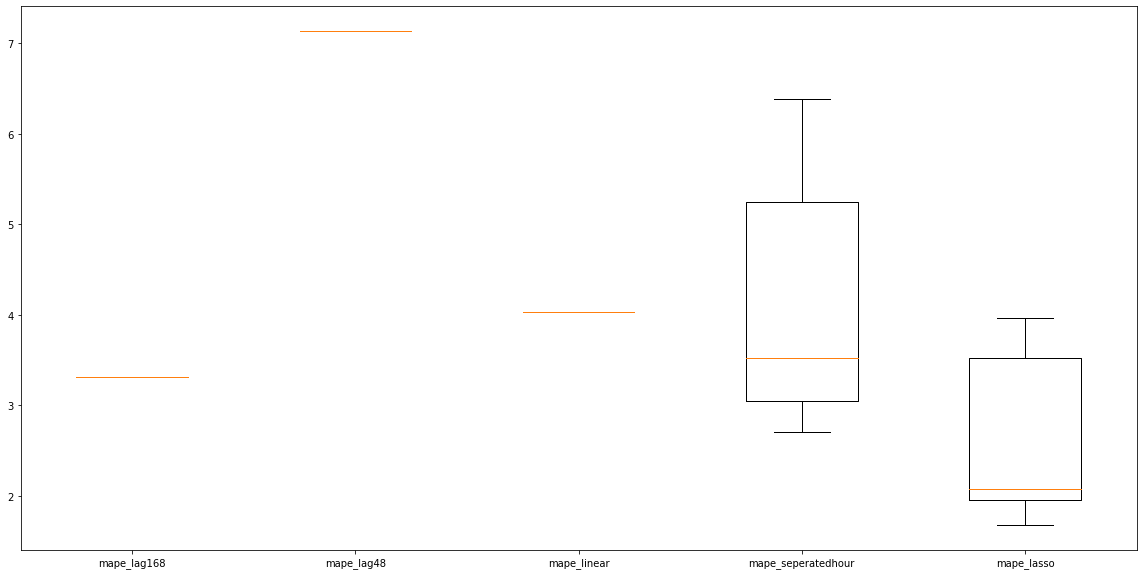

In [50]:
plt.figure(figsize=(20,10))

d1 = 24*[lag168_mape]
d2 = 24*[lag48_mape]
d3 = 24*[linear_mape1]
d4 = mape_results
d5 = mape_results_lasso
data = [d1, d2, d3, d4, d5]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5], ['mape_lag168', 'mape_lag48', 'mape_linear', 'mape_seperatedhour', 'mape_lasso'])
plt.show()